In [ ]:
pip uninstall numpy -y


In [ ]:
pip install "numpy>=2.0.0"


In [1]:
import numpy
print(numpy.__version__)

2.2.6


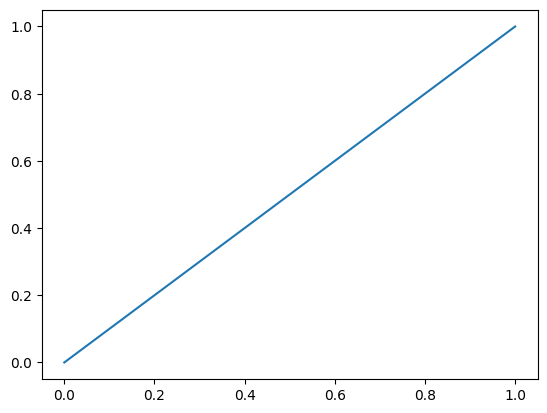

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot([0,1],[0,1])
plt.show()


In [4]:
import torch
import numpy as np
import scipy.sparse as sp
from torch_geometric.data import Data
print("✅ All imports successful!")


d:\Football-Tactical-Clustering-main\Football-Tactical-Clustering-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports successful!


In [5]:
import sys
print("Python:", sys.version)
import numpy, scipy, torch
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("PyTorch:", torch.__version__)


Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
NumPy: 2.2.6
SciPy: 1.15.3
PyTorch: 2.9.0+cpu


In [ ]:
pip install --upgrade --force-reinstall "scipy>=1.14.1"


In [ ]:
pip install --upgrade numpy

In [6]:
import pickle
import glob
import os

# Path to your folder containing the .pkl files
folder_path = "./graphs"   # or "/absolute/path/to/graphs" if outside your project folder

graphs = []

# Loop through all .pkl files in the folder
for file in glob.glob(os.path.join(folder_path, "*.pkl")):
    with open(file, 'rb') as f:
        graphs.append(pickle.load(f))

print(f"Loaded {len(graphs)} graphs successfully!")


Loaded 112 graphs successfully!


In [8]:
import pickle
import glob
import os
import re
from collections import defaultdict

folder_path = "./graphs"

# Dictionary: teamID → list of graphs
team_graphs = defaultdict(list)

# Regex pattern to extract teamID from filenames
pattern = re.compile(r'team(\d+)\.pkl')

for file in glob.glob(os.path.join(folder_path, "graph_match*_team*.pkl")):
    match = pattern.search(file)
    if match:
        team_id = int(match.group(1))  # convert to integer if needed
        with open(file, 'rb') as f:
            graph = pickle.load(f)
        team_graphs[team_id].append(graph)

print(f"Loaded graphs for {len(team_graphs)} teams:")
for team_id, graphs in team_graphs.items():
    print(f"  Team {team_id}: {len(graphs)} graphs")


Loaded graphs for 3 teams:
  Team 1609: 38 graphs
  Team 1625: 37 graphs
  Team 1612: 37 graphs


In [44]:
# Map numeric team IDs to friendly names
team_name_map = {
    1609: "TeamA",
    1625: "TeamB",
    1612: "TeamC"
}

# Build new dictionary with readable team names
team_graphs_dict = {
    team_name_map[team_id]: graphs
    for team_id, graphs in team_graphs.items()
    if team_id in team_name_map
}

# Quick summary
for name, graphs in team_graphs_dict.items():
    print(f"{name}: {len(graphs)} graphs")


TeamA: 38 graphs
TeamB: 37 graphs
TeamC: 37 graphs


In [45]:
print(type(team_graphs_dict))  # should be <class 'dict'>
print(team_graphs_dict.keys()) # should show dict keys like TeamA, TeamB


<class 'dict'>
dict_keys(['TeamA', 'TeamB', 'TeamC'])


In [10]:
# ===========================================
#  TEAM-LEVEL GCN AUTOENCODER FOR TACTICAL CLUSTERING
# ===========================================
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
import networkx as nx
import numpy as np
from tqdm import tqdm


# -----------------------------
# 1. Prepare each graph as PyG data
# -----------------------------
def prepare_pyg_data(G, zt=None, add_spatial=True, add_topo=True):
    """
    Converts a zone transition graph into a PyTorch Geometric Data object.
    Includes structural, statistical, and spatial node features.
    """

    features = []

    # Optionally precompute graph-level topological measures
    if add_topo:
        clustering = nx.clustering(G, weight="weight")
        pagerank = nx.pagerank(G, weight="weight")

    for n in G.nodes():
        # --- Structural degrees ---
        in_deg = G.in_degree(n, weight="weight")
        out_deg = G.out_degree(n, weight="weight")
        total_w = in_deg + out_deg

        # --- From your existing node attributes ---
        event_count = G.nodes[n].get("event_count", 0)
        unique_players = G.nodes[n].get("unique_players", 0)

        # Role distribution (GK, DF, MD, FW)
        role_dist = G.nodes[n].get("role_distribution", [0, 0, 0, 0])

        # Encode most_common_event (categorical) → one-hot
        event_type = G.nodes[n].get("most_common_event", None)
        event_types = ["pass", "shot", "dribble", "cross", "duel"]  # adjust for your dataset
        event_onehot = [1.0 if event_type == et else 0.0 for et in event_types]

        # --- Optional spatial coordinates ---
        if zt is not None and add_spatial:
            x_center, y_center = zt.get_zone_center(n)
            x_center, y_center = x_center / 100, y_center / 100
        else:
            x_center, y_center = 0.0, 0.0

        # --- Optional topological measures ---
        if add_topo:
            cluster_coeff = clustering.get(n, 0.0)
            pr = pagerank.get(n, 0.0)
        else:
            cluster_coeff = pr = 0.0

        # --- Combine all features ---
        features.append([
            in_deg, out_deg, total_w,
            event_count, unique_players,
            cluster_coeff, pr,
            *role_dist,
            *event_onehot,
            x_center, y_center
        ])

    X = torch.tensor(np.array(features, dtype=float), dtype=torch.float32)

    # Build PyG Data
    data = from_networkx(G)
    data.x = X

    # Edge attributes (weights)
    data.edge_attr = torch.tensor(
        [G[u][v].get("weight", 1.0) for u, v in G.edges()],
        dtype=torch.float32
    )

    return data



# -----------------------------
# 2. Define the GCN Autoencoder
# -----------------------------
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, latent_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        z = self.conv2(x, edge_index, edge_weight=edge_weight)
        return z


class GraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super().__init__()
        self.encoder = GCNEncoder(in_channels, hidden_channels, latent_channels)

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index, data.edge_attr)
        # Adjacency reconstruction (inner product)
        adj_pred = torch.sigmoid(torch.mm(z, z.t()))
        return adj_pred, z


# -----------------------------
# 3. Train on all team graphs jointly
# -----------------------------
def train_team_autoencoder(team_graphs, zt=None, hidden_dim=16, latent_dim=3,
                           epochs=200, lr=0.005, batch_size=1, device="cpu"):

    # Prepare PyG data objects
    data_list = [prepare_pyg_data(G, zt) for G in team_graphs]
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

    # Model setup
    in_dim = data_list[0].x.shape[1]
    model = GraphAutoencoder(in_dim, hidden_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.train()
    for epoch in tqdm(range(epochs), desc="Training GCN Autoencoder"):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            A_pred, _ = model(data)

            # Ground-truth adjacency
            A_true = torch.zeros_like(A_pred)
            for i, (u, v) in enumerate(data.edge_index.t()):
                A_true[u, v] = 1.0

            loss = F.mse_loss(A_pred, A_true)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    return model


# -----------------------------
# 4. Extract embeddings for each match
# -----------------------------
def get_team_embeddings(model, team_graphs, zt=None, device="cpu"):
    model.eval()
    embeddings_per_match = []
    with torch.no_grad():
        for G in team_graphs:
            data = prepare_pyg_data(G, zt).to(device)
            _, z = model(data)
            # Instead of .numpy(), just keep as list
            embeddings_per_match.append(z.cpu().tolist())
    return embeddings_per_match



# -----------------------------
# 5. Example usage
# -----------------------------
# Suppose you have a dict of team graphs:
# team_graphs_dict = {
#     "TeamA": [G_A1, G_A2, ..., G_A40],
#     "TeamB": [G_B1, G_B2, ..., G_B40],
#     "TeamC": [G_C1, G_C2, ..., G_C40],
# }

# Example run for Team A:
# model_A = train_team_autoencoder(team_graphs_dict["TeamA"], zt, epochs=200)
# embeddings_A = get_team_embeddings(model_A, team_graphs_dict["TeamA"], zt)
#
# np.save("teamA_zone_embeddings.npy", embeddings_A)


In [12]:
import numpy as np
import pandas as pd

class ZoneTransformer:
    """Simplified version for zone grid + coordinate mapping."""

    def __init__(self):
        # Grid segmentation (8x5 layout)
        self.width_segments = [6, 10, 17, 17, 17, 17, 10, 6]
        self.height_segments = [19, 18, 26, 18, 19]

        self.n_rows = len(self.height_segments)
        self.n_cols = len(self.width_segments)
        self.n_zones = self.n_rows * self.n_cols  # 8 x 5
        self.outside_zone_id = self.n_zones

        self.width_boundaries = np.cumsum([0] + self.width_segments)
        self.height_boundaries = np.cumsum([0] + self.height_segments)
        self.zone_names = self._create_zone_names()

    def _create_zone_names(self):
        row_names = ["RIGHT_WING", "RIGHT_HALF", "CENTER", "LEFT_HALF", "LEFT_WING"]
        col_names = [
            "DEF_BOX",
            "DEF_PENALTY",
            "DEF_THIRD_DEEP",
            "DEF_THIRD",
            "MID_THIRD_DEF",
            "MID_THIRD_ATT",
            "ATT_THIRD",
            "ATT_PENALTY",
        ]
        names = {}
        for col in range(self.n_cols):
            for row in range(self.n_rows):
                zid = self.rowcol_to_id(row, col)
                names[zid] = f"{row_names[row]}_{col_names[col]}"
        names[self.outside_zone_id] = "OUTSIDE"
        return names

    def rowcol_to_id(self, row, col):
        if row < 0 or row >= self.n_rows or col < 0 or col >= self.n_cols:
            return self.outside_zone_id
        return col * self.n_rows + (self.n_rows - row - 1)

    def id_to_rowcol(self, zid):
        if zid == self.outside_zone_id:
            return (-1, -1)
        row = self.n_rows - (zid % self.n_rows) - 1
        col = zid // self.n_rows
        return (row, col)

    def get_zone_bounds(self, zid):
        if zid == self.outside_zone_id:
            return (100.0, 100.0, 100.0, 100.0)
        row, col = self.id_to_rowcol(zid)
        x_min = self.width_boundaries[col]
        x_max = self.width_boundaries[col + 1]
        y_min = self.height_boundaries[row]
        y_max = self.height_boundaries[row + 1]
        return (x_min, x_max, y_min, y_max)

    def get_zone_center(self, zid):
        if zid == self.outside_zone_id:
            return (100.0, 100.0)
        x_min, x_max, y_min, y_max = self.get_zone_bounds(zid)
        return ((x_min + x_max) / 2, (y_min + y_max) / 2)

    def get_zone_name(self, zid):
        return self.zone_names.get(zid, f"ZONE_{zid}")


In [13]:

zt = ZoneTransformer()


In [14]:
import numpy, torch, scipy
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("PyTorch:", torch.__version__)


NumPy: 2.2.6
SciPy: 1.15.3
PyTorch: 2.9.0+cpu


In [15]:
#Models training

model_A = train_team_autoencoder(team_graphs_dict["TeamA"], zt, epochs=200)
model_B = train_team_autoencoder(team_graphs_dict["TeamB"], zt, epochs=200)
model_C = train_team_autoencoder(team_graphs_dict["TeamC"], zt, epochs=200)


d:\Football-Tactical-Clustering-main\Football-Tactical-Clustering-main\venv\lib\site-packages\torch_geometric\utils\convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  data_dict[key] = torch.as_tensor(value)
Training GCN Autoencoder:  10%|█         | 20/200 [00:11<01:54,  1.58it/s]

Epoch 20/200, Loss: 9.0999


Training GCN Autoencoder:  20%|██        | 40/200 [00:22<01:23,  1.93it/s]

Epoch 40/200, Loss: 8.7799


Training GCN Autoencoder:  30%|███       | 60/200 [00:32<01:13,  1.90it/s]

Epoch 60/200, Loss: 8.7498


Training GCN Autoencoder:  40%|████      | 80/200 [00:43<01:04,  1.87it/s]

Epoch 80/200, Loss: 8.7435


Training GCN Autoencoder:  50%|█████     | 100/200 [00:54<00:52,  1.92it/s]

Epoch 100/200, Loss: 8.6765


Training GCN Autoencoder:  60%|██████    | 120/200 [01:04<00:42,  1.89it/s]

Epoch 120/200, Loss: 8.5490


Training GCN Autoencoder:  70%|███████   | 140/200 [01:15<00:31,  1.91it/s]

Epoch 140/200, Loss: 8.7205


Training GCN Autoencoder:  80%|████████  | 160/200 [01:25<00:21,  1.90it/s]

Epoch 160/200, Loss: 8.5385


Training GCN Autoencoder:  90%|█████████ | 180/200 [01:36<00:10,  1.92it/s]

Epoch 180/200, Loss: 8.6334


Training GCN Autoencoder: 100%|██████████| 200/200 [01:46<00:00,  1.87it/s]

Epoch 200/200, Loss: 8.6820



Training GCN Autoencoder:  10%|█         | 20/200 [00:10<01:32,  1.94it/s]

Epoch 20/200, Loss: 14.3092


Training GCN Autoencoder:  20%|██        | 40/200 [00:20<01:23,  1.92it/s]

Epoch 40/200, Loss: 9.0910


Training GCN Autoencoder:  30%|███       | 60/200 [00:31<01:12,  1.92it/s]

Epoch 60/200, Loss: 9.1199


Training GCN Autoencoder:  40%|████      | 80/200 [00:41<01:02,  1.94it/s]

Epoch 80/200, Loss: 9.1775


Training GCN Autoencoder:  50%|█████     | 100/200 [00:52<00:51,  1.95it/s]

Epoch 100/200, Loss: 8.5798


Training GCN Autoencoder:  60%|██████    | 120/200 [01:03<00:44,  1.82it/s]

Epoch 120/200, Loss: 8.6468


Training GCN Autoencoder:  70%|███████   | 140/200 [01:14<00:31,  1.93it/s]

Epoch 140/200, Loss: 8.6645


Training GCN Autoencoder:  80%|████████  | 160/200 [01:24<00:20,  1.92it/s]

Epoch 160/200, Loss: 8.5303


Training GCN Autoencoder:  90%|█████████ | 180/200 [01:35<00:10,  1.93it/s]

Epoch 180/200, Loss: 8.4116


Training GCN Autoencoder: 100%|██████████| 200/200 [01:45<00:00,  1.89it/s]

Epoch 200/200, Loss: 8.4059



Training GCN Autoencoder:  10%|█         | 20/200 [00:10<01:30,  1.98it/s]

Epoch 20/200, Loss: 9.2292


Training GCN Autoencoder:  20%|██        | 40/200 [00:20<01:20,  1.99it/s]

Epoch 40/200, Loss: 8.7038


Training GCN Autoencoder:  30%|███       | 60/200 [00:31<01:34,  1.49it/s]

Epoch 60/200, Loss: 8.5541


Training GCN Autoencoder:  40%|████      | 80/200 [00:44<01:23,  1.43it/s]

Epoch 80/200, Loss: 8.9067


Training GCN Autoencoder:  50%|█████     | 100/200 [00:58<01:08,  1.46it/s]

Epoch 100/200, Loss: 8.4817


Training GCN Autoencoder:  60%|██████    | 120/200 [01:11<00:52,  1.52it/s]

Epoch 120/200, Loss: 8.6464


Training GCN Autoencoder:  70%|███████   | 140/200 [01:25<00:39,  1.51it/s]

Epoch 140/200, Loss: 8.6200


Training GCN Autoencoder:  80%|████████  | 160/200 [01:39<00:29,  1.37it/s]

Epoch 160/200, Loss: 8.4949


Training GCN Autoencoder:  90%|█████████ | 180/200 [01:52<00:12,  1.62it/s]

Epoch 180/200, Loss: 8.5804


Training GCN Autoencoder: 100%|██████████| 200/200 [02:04<00:00,  1.61it/s]

Epoch 200/200, Loss: 8.5685


In [83]:
#kmeans clustering + visualizations
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# -----------------------------
# 1. Compute team-level embeddings
# -----------------------------
def compute_team_embeddings(embeddings_per_match):
    """
    Average node embeddings across matches for consistent team-level representation.
    embeddings_per_match: list of matches, each is list of node embeddings per node
    Returns: np.array of shape (num_zones, latent_dim)
    """
    zone_embeddings_dict = defaultdict(list)
    for match_emb in embeddings_per_match:
        for node_id, z in enumerate(match_emb):
            zone_embeddings_dict[node_id].append(z)

    num_zones = max(zone_embeddings_dict.keys()) + 1
    latent_dim = len(next(iter(zone_embeddings_dict.values()))[0])
    team_embeddings = np.zeros((num_zones, latent_dim))

    for node_id, emb_list in zone_embeddings_dict.items():
        team_embeddings[node_id] = np.mean(emb_list, axis=0)

    return team_embeddings

# -----------------------------
# 2. KMeans clustering
# -----------------------------
def kmeans_numpy(X, n_clusters=3, n_iters=100, verbose=False):
    n_samples, n_features = X.shape
    indices = np.random.permutation(n_samples)[:n_clusters]
    centroids = X[indices]

    for i in range(n_iters):
        dists = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
        cluster_ids = np.argmin(dists, axis=1)
        new_centroids = np.array([
            X[cluster_ids == k].mean(axis=0) if np.any(cluster_ids == k) else centroids[k]
            for k in range(n_clusters)
        ])
        if np.allclose(centroids, new_centroids):
            if verbose:
                print(f"KMeans converged at iteration {i+1}")
            break
        centroids = new_centroids
        if verbose:
            print(f"Iteration {i+1} done")
    return cluster_ids, centroids

# -----------------------------
# 3. Visualize clusters on pitch
# -----------------------------
def visualize_clusters(G, labels, zt=None, figsize=(12,8), title="Deep Zone Clustering"):
    """
    G: NetworkX graph (canonical team graph with all zones)
    labels: 1D array of cluster IDs per node
    zt: optional object with get_zone_center(node)
    """
    plt.figure(figsize=figsize)

    if zt is not None and hasattr(zt, "get_zone_center"):
        pos = {n: zt.get_zone_center(n) for n in G.nodes()}
    else:
        pos = nx.spring_layout(G, seed=42)

    labels = np.array(labels)
    colors = plt.cm.tab10(labels.astype(int) % 10)

    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=800, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(title)
    plt.axis("off")
    plt.show()

# -----------------------------
# 4. End-to-end workflow for all teams
# -----------------------------
def cluster_and_visualize_all_teams(team_graphs_dict, embeddings_dict, zt=None, n_clusters=3):
    """
    team_graphs_dict: {"TeamA": [G1, G2, ...], ...}
    embeddings_dict: {"TeamA": embeddings_per_match, ...}
    """
    for team_name, graphs in team_graphs_dict.items():
        print(f"\nProcessing {team_name}...")

        # Step 1: Compute team-level embeddings
        embeddings_per_match = embeddings_dict[team_name]
        team_embeddings = compute_team_embeddings(embeddings_per_match)

        # Step 2: KMeans clustering
        cluster_ids, _ = kmeans_numpy(team_embeddings, n_clusters=n_clusters, verbose=True)

        # Step 3: Build canonical team graph (all nodes from first match)
        # Number of zones from embeddings
        num_zones = team_embeddings.shape[0]
        
        # Build canonical graph using all nodes
        canonical_graph = nx.Graph()
        canonical_graph.add_nodes_from(graphs[0].nodes(data=True))
        canonical_graph.add_edges_from(graphs[0].edges(data=True))

        nodes_in_graph = list(canonical_graph.nodes())
        cluster_ids_filtered = [cluster_ids[n] for n in nodes_in_graph]
        # Optional: add edges if you have adjacency info
        # canonical_graph.add_edges_from(some_edges)
        # cluster_ids has length == num_zones, guaranteed match
        visualize_clusters(canonical_graph, cluster_ids_filtered, zt, title=f"{team_name} Tactical Zones")
        return canonical_graph  # 👈 add this

# -----------------------------
# Example usage:
# -----------------------------
# team_graphs_dict = {"TeamA": [G_A1, G_A2, ...], ...}
# embeddings_dict = {"TeamA": embeddings_A, ...}  # output of get_team_embeddings()
# cluster_and_visualize_all_teams(team_graphs_dict, embeddings_dict, zt, n_clusters=3)



Processing TeamA...
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
KMeans converged at iteration 5


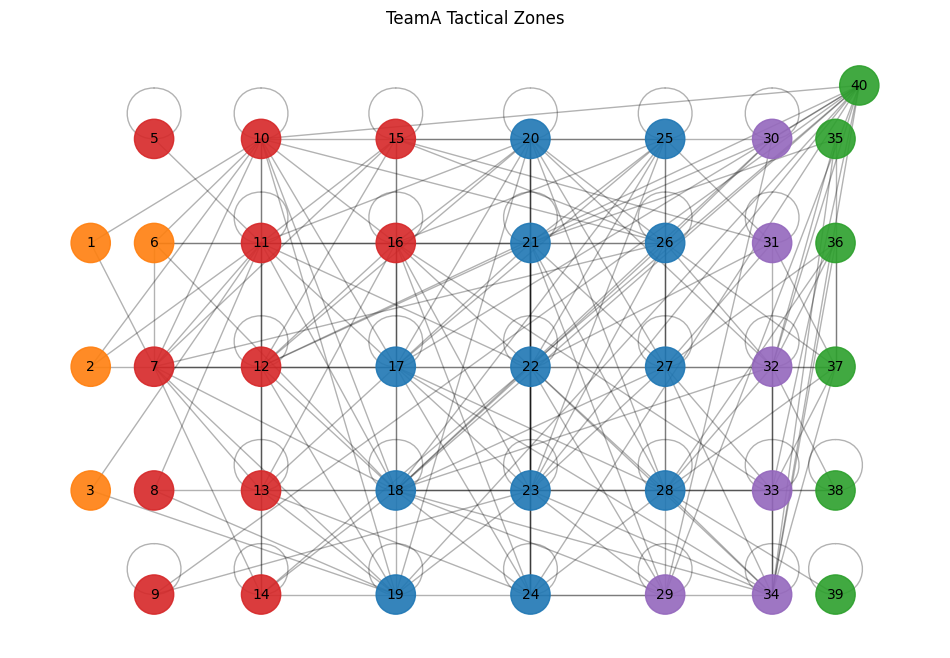

In [70]:
embeddings_A = get_team_embeddings(model_A, team_graphs_dict["TeamA"], zt)

cluster_and_visualize_all_teams(
    {"TeamA": team_graphs_dict["TeamA"]},
    {"TeamA": embeddings_A},
    zt,
    n_clusters=5
)



Processing TeamB...
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
KMeans converged at iteration 5


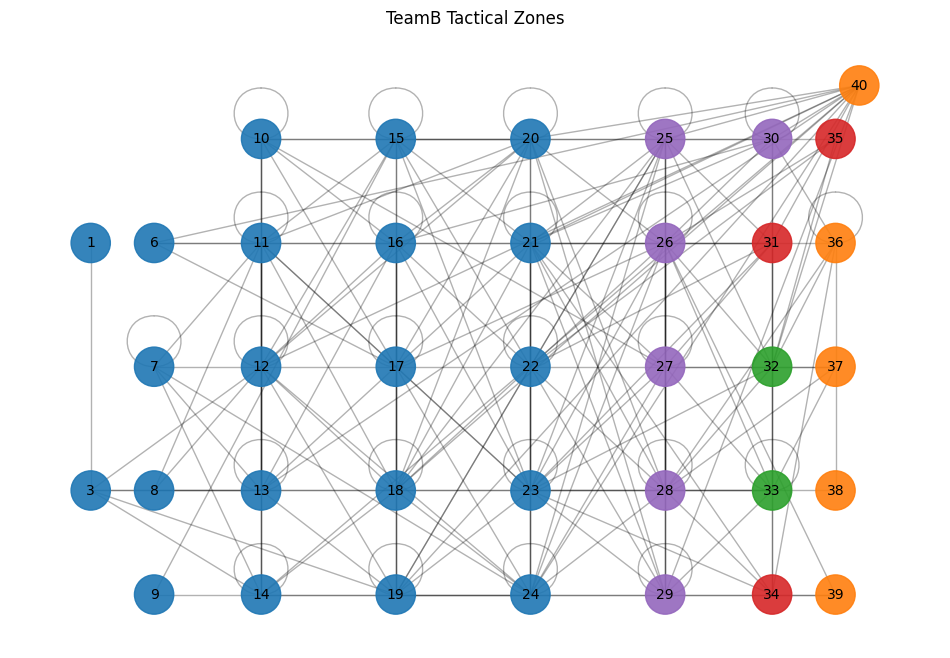

In [71]:
embeddings_B = get_team_embeddings(model_B, team_graphs_dict["TeamB"], zt)

cluster_and_visualize_all_teams(
    {"TeamB": team_graphs_dict["TeamB"]},
    {"TeamB": embeddings_B},
    zt,
    n_clusters=5
)



Processing TeamC...
Iteration 1 done
Iteration 2 done
Iteration 3 done
Iteration 4 done
KMeans converged at iteration 5


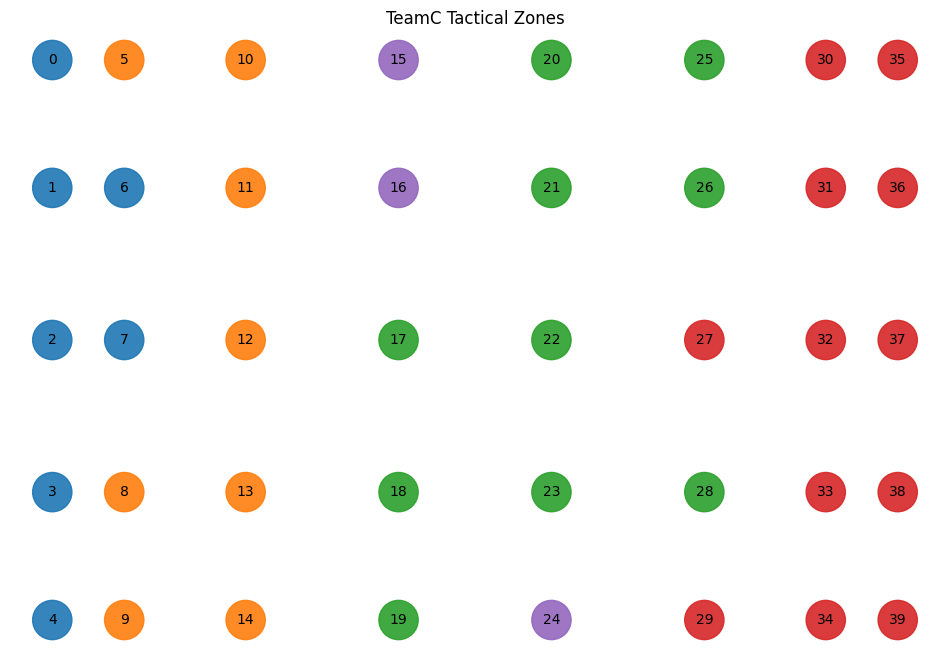

In [68]:
embeddings_C = get_team_embeddings(model_C, team_graphs_dict["TeamC"], zt)

cluster_and_visualize_all_teams(
    {"TeamC": team_graphs_dict["TeamC"]},
    {"TeamC": embeddings_C},
    zt,
    n_clusters=5
)


In [73]:
from sklearn.metrics import silhouette_score

def evaluate_silhouette(embeddings, cluster_ids):
    """
    embeddings: numpy array of shape (n_nodes, latent_dim)
    cluster_ids: array of shape (n_nodes,)
    """
    if len(np.unique(cluster_ids)) < 2:
        print("Silhouette score not defined for a single cluster.")
        return None
    return silhouette_score(embeddings, cluster_ids)


In [74]:
from sklearn.metrics import adjusted_rand_score

def evaluate_ari(cluster_ids, ground_truth_labels):
    """
    cluster_ids: predicted cluster IDs
    ground_truth_labels: known labels (same length)
    """
    return adjusted_rand_score(ground_truth_labels, cluster_ids)


In [84]:
import networkx as nx
from networkx.algorithms.community import modularity

def evaluate_modularity(G, cluster_ids):
    """
    G: networkx Graph
    cluster_ids: array of cluster IDs per node
    """
    # Group nodes by cluster
    communities = []
    labels = np.array(cluster_ids)
    for c in np.unique(labels):
        communities.append(set(np.where(labels == c)[0]))
    
    # Compute modularity
    return modularity(G, communities)


In [87]:
def evaluate_team_clustering(team_name, embeddings, cluster_ids, G=None):
    print(f"\n=== Evaluating clustering for {team_name} ===")
    
    # --- Silhouette ---
    try:
        sil = silhouette_score(embeddings, cluster_ids)
        print(f"Silhouette score: {sil:.3f}")
    except Exception as e:
        print(f"Silhouette score could not be computed: {e}")
    
    # --- ARI ---
    print("ARI requires ground truth, skipping unless available.")
    
    # --- Modularity ---
    if G is not None:
        valid_nodes = list(G.nodes())
        node_id_to_index = {n: i for i, n in enumerate(valid_nodes)}

        # Filter cluster_ids to match only existing nodes
        valid_cluster_ids = [cluster_ids[i] for i in node_id_to_index.values() if i < len(cluster_ids)]

        # Build partition
        communities = []
        for c in np.unique(valid_cluster_ids):
            comm_nodes = [n for n, cid in zip(valid_nodes, valid_cluster_ids) if cid == c]
            if len(comm_nodes) > 0:
                communities.append(set(comm_nodes))

        try:
            mod = nx.community.modularity(G, communities)
            print(f"Modularity: {mod:.3f}")
        except Exception as e:
            print(f"Modularity computation failed: {e}")


In [78]:
import numpy as np

def compute_team_embeddings(embeddings_per_match):
    """
    embeddings_per_match: list of arrays (num_nodes, latent_dim)
    Returns averaged embedding per node ID
    """
    # Find the max node index (assuming node IDs start at 0)
    max_nodes = max(e.shape[0] for e in embeddings_per_match)
    latent_dim = embeddings_per_match[0].shape[1]

    # Initialize accumulators
    sums = np.zeros((max_nodes, latent_dim))
    counts = np.zeros(max_nodes)

    # Accumulate embeddings per node across matches
    for emb in embeddings_per_match:
        for i in range(emb.shape[0]):
            sums[i] += emb[i]
            counts[i] += 1

    # Avoid division by zero
    counts[counts == 0] = 1
    avg_embeddings = sums / counts[:, None]
    return avg_embeddings


In [89]:
avg_embeddings_A = compute_team_embeddings([
    np.array(match_emb) for match_emb in embeddings_A
])

avg_embeddings_B= compute_team_embeddings([
    np.array(match_emb) for match_emb in embeddings_B
])

avg_embeddings_C = compute_team_embeddings([
    np.array(match_emb) for match_emb in embeddings_C
])

In [93]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def cluster_and_visualize_all_teams(team_graphs_dict, embeddings_dict, zt=None, n_clusters=3):
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler

    canonical_graphs = {}

    for team_name, graphs in team_graphs_dict.items():
        print(f"\n=== Processing {team_name} ===")

        # -------------------------------
        # 1. Prepare canonical graph
        # -------------------------------
        canonical_graph = nx.DiGraph()
        canonical_graph.add_nodes_from(graphs[0].nodes(data=True))
        canonical_graph.add_edges_from(graphs[0].edges(data=True))
        nodes_in_graph = list(canonical_graph.nodes())
        num_nodes = len(nodes_in_graph)

        # -------------------------------
        # 2. Flatten embeddings per match
        # -------------------------------
        embeddings_all = []
        for match_emb in embeddings_dict[team_name]:
            match_emb = np.array(match_emb)
            if match_emb.shape[0] == num_nodes:
                embeddings_all.append(match_emb)
            else:
                # Align by trimming or padding
                print(f"⚠️ Match embedding size {match_emb.shape[0]} != graph size {num_nodes}, aligning...")
                min_len = min(match_emb.shape[0], num_nodes)
                fixed = np.zeros((num_nodes, match_emb.shape[1]))
                fixed[:min_len, :] = match_emb[:min_len, :]
                embeddings_all.append(fixed)

        embeddings_all = np.stack(embeddings_all, axis=0)
        avg_embeddings = embeddings_all.mean(axis=0)

        # -------------------------------
        # 3. KMeans clustering
        # -------------------------------
        X = StandardScaler().fit_transform(avg_embeddings)
        cluster_ids, centroids = kmeans_numpy(X, n_clusters=n_clusters, n_iters=100)
        print(f"Clusters found: {np.bincount(cluster_ids)}")

        # -------------------------------
        # 4. Visualization
        # -------------------------------
        visualize_clusters(
            canonical_graph,
            avg_embeddings,
            cluster_ids,
            zt,
            title=f"{team_name} Tactical Zone Clusters"
        )

        canonical_graphs[team_name] = canonical_graph

    return canonical_graphs


In [94]:
def visualize_clusters(G, embeddings, labels, zt=None, figsize=(12,8), title="Deep Zone Clustering"):
    plt.figure(figsize=figsize)
    if zt is not None and hasattr(zt, "get_zone_center"):
        pos = {n: zt.get_zone_center(n) for n in G.nodes()}
    else:
        pos = nx.spring_layout(G, seed=42)

    # Ensure same number of colors as nodes
    labels = np.array(labels)
    if len(labels) != len(G.nodes()):
        labels = labels[:len(G.nodes())]

    colors = plt.cm.tab10(labels.astype(int) % 10)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=800, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title)
    plt.axis("off")
    plt.show()



=== Processing TeamC ===
⚠️ Match embedding size 37 != graph size 38, aligning...
⚠️ Match embedding size 39 != graph size 38, aligning...
⚠️ Match embedding size 36 != graph size 38, aligning...
⚠️ Match embedding size 39 != graph size 38, aligning...
⚠️ Match embedding size 40 != graph size 38, aligning...
⚠️ Match embedding size 39 != graph size 38, aligning...
⚠️ Match embedding size 36 != graph size 38, aligning...
⚠️ Match embedding size 40 != graph size 38, aligning...
⚠️ Match embedding size 36 != graph size 38, aligning...
⚠️ Match embedding size 37 != graph size 38, aligning...
⚠️ Match embedding size 37 != graph size 38, aligning...
⚠️ Match embedding size 36 != graph size 38, aligning...
⚠️ Match embedding size 37 != graph size 38, aligning...
⚠️ Match embedding size 37 != graph size 38, aligning...
⚠️ Match embedding size 37 != graph size 38, aligning...
⚠️ Match embedding size 37 != graph size 38, aligning...
⚠️ Match embedding size 39 != graph size 38, aligning...
⚠️ Ma

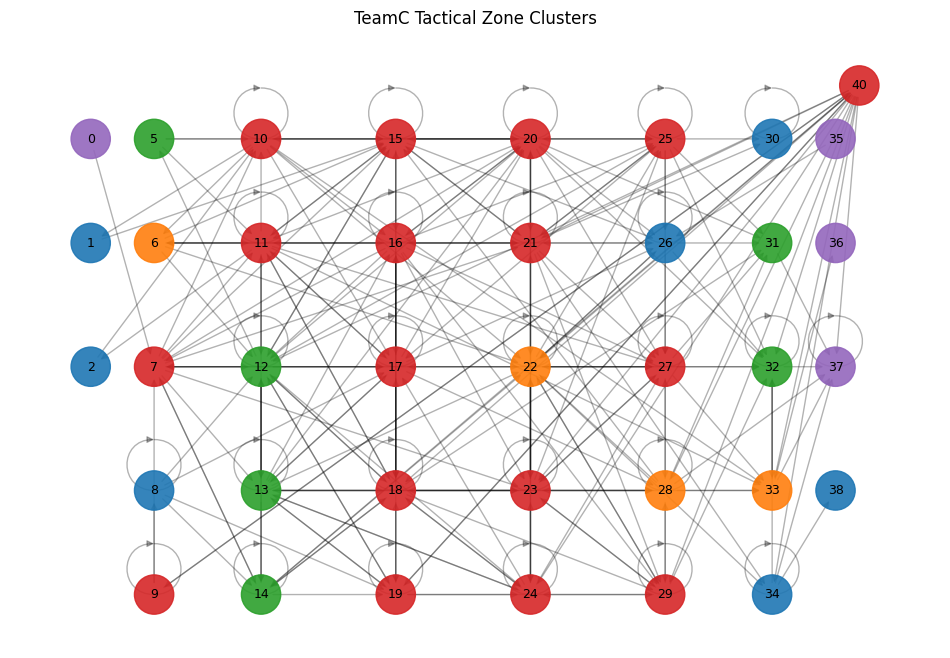


=== Evaluating clustering for TeamC ===
Silhouette score: 0.391
ARI requires ground truth, skipping unless available.
Modularity: 0.075


In [97]:
# Step 1: Cluster and visualize all matches for Team C
canonical_graphs = cluster_and_visualize_all_teams(
    {"TeamC": team_graphs_dict["TeamC"]},
    {"TeamC": embeddings_C},
    zt,
    n_clusters=5
)

# Step 2: Extract the actual graph
canonical_graph_C = canonical_graphs["TeamC"]

# Step 3: Compute evaluation metrics
evaluate_team_clustering("TeamC", avg_embeddings_C, cluster_ids_C, G=canonical_graph_C)



=== Processing TeamA ===
⚠️ Match embedding size 37 != graph size 39, aligning...
⚠️ Match embedding size 38 != graph size 39, aligning...
⚠️ Match embedding size 37 != graph size 39, aligning...
⚠️ Match embedding size 37 != graph size 39, aligning...
⚠️ Match embedding size 36 != graph size 39, aligning...
⚠️ Match embedding size 40 != graph size 39, aligning...
⚠️ Match embedding size 40 != graph size 39, aligning...
⚠️ Match embedding size 36 != graph size 39, aligning...
⚠️ Match embedding size 40 != graph size 39, aligning...
⚠️ Match embedding size 40 != graph size 39, aligning...
⚠️ Match embedding size 37 != graph size 39, aligning...
⚠️ Match embedding size 38 != graph size 39, aligning...
⚠️ Match embedding size 37 != graph size 39, aligning...
⚠️ Match embedding size 38 != graph size 39, aligning...
⚠️ Match embedding size 34 != graph size 39, aligning...
⚠️ Match embedding size 41 != graph size 39, aligning...
⚠️ Match embedding size 38 != graph size 39, aligning...
⚠️ Ma

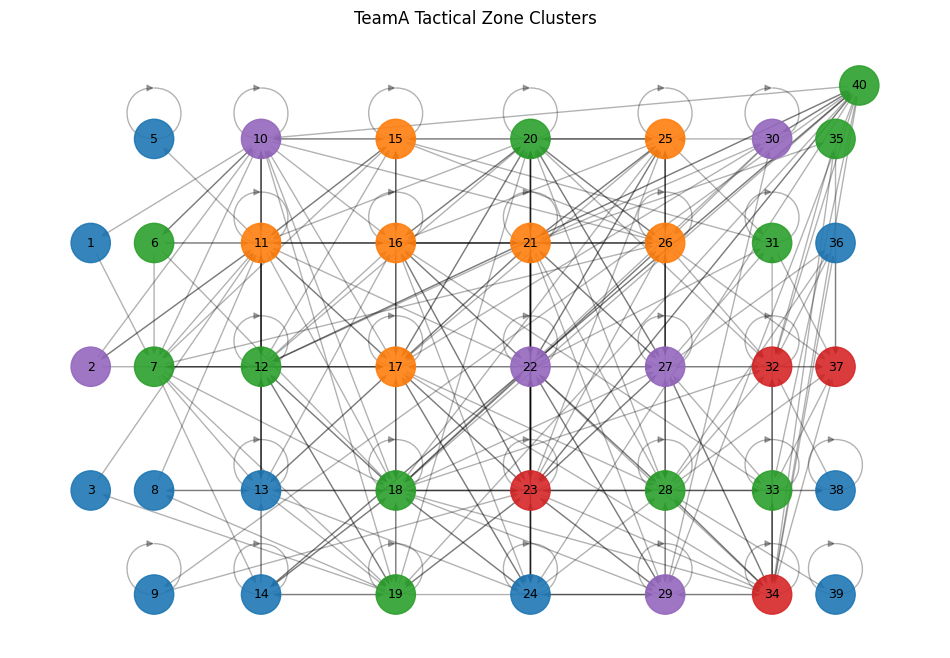


=== Processing TeamB ===
⚠️ Match embedding size 38 != graph size 37, aligning...
⚠️ Match embedding size 39 != graph size 37, aligning...
⚠️ Match embedding size 38 != graph size 37, aligning...
⚠️ Match embedding size 39 != graph size 37, aligning...
⚠️ Match embedding size 38 != graph size 37, aligning...
⚠️ Match embedding size 38 != graph size 37, aligning...
⚠️ Match embedding size 39 != graph size 37, aligning...
⚠️ Match embedding size 41 != graph size 37, aligning...
⚠️ Match embedding size 40 != graph size 37, aligning...
⚠️ Match embedding size 40 != graph size 37, aligning...
⚠️ Match embedding size 39 != graph size 37, aligning...
⚠️ Match embedding size 40 != graph size 37, aligning...
⚠️ Match embedding size 41 != graph size 37, aligning...
⚠️ Match embedding size 40 != graph size 37, aligning...
⚠️ Match embedding size 41 != graph size 37, aligning...
⚠️ Match embedding size 40 != graph size 37, aligning...
⚠️ Match embedding size 38 != graph size 37, aligning...
⚠️ Ma

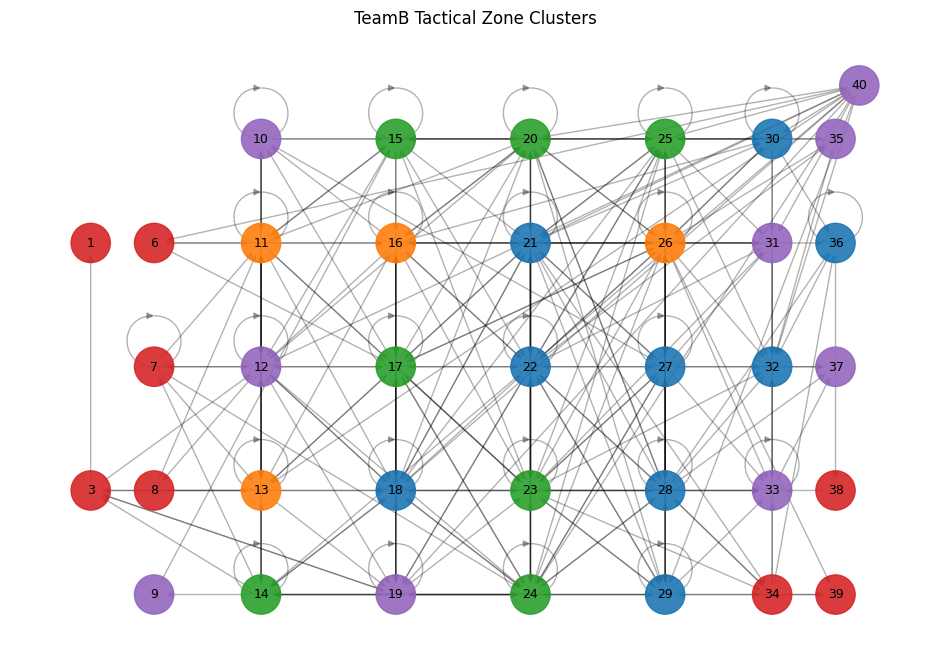

In [98]:
canonical_graph_A = cluster_and_visualize_all_teams(
    {"TeamA": team_graphs_dict["TeamA"]},
    {"TeamA": embeddings_A},
    zt,
    n_clusters=5
)

canonical_graph_B = cluster_and_visualize_all_teams(
    {"TeamB": team_graphs_dict["TeamB"]},
    {"TeamB": embeddings_B},
    zt,
    n_clusters=5
)


In [88]:
cluster_ids_A, centroids_A = kmeans_numpy(avg_embeddings_A, n_clusters=5)
evaluate_team_clustering("TeamA", avg_embeddings_A, cluster_ids_A, G=canonical_graph_A)



=== Evaluating clustering for TeamA ===
Silhouette score: 0.478
ARI requires ground truth, skipping unless available.
Modularity: 0.147


In [92]:
cluster_ids_B, centroids_B = kmeans_numpy(avg_embeddings_B, n_clusters=5)
evaluate_team_clustering("TeamB", avg_embeddings_B, cluster_ids_B, G=canonical_graph_B)



=== Evaluating clustering for TeamB ===
Silhouette score: 0.372
ARI requires ground truth, skipping unless available.
Modularity: 0.146
